# Multilingual Embedding - Fine Tunning on ( Arabic - French ) Before Testing

In [1]:
from gensim.models import KeyedVectors
from sklearn.metrics import classification_report

fr_embeddings = KeyedVectors.load_word2vec_format("wiki.multi.fr.vec")
en_embeddings = KeyedVectors.load_word2vec_format("wiki.multi.en.vec")


from gensim.models import KeyedVectors
import numpy as np

ar_embeddings = KeyedVectors.load_word2vec_format("wiki.multi.ar.vec", limit=50000)

# Pad the vectors with zeros to match the desired dimensionality (300 in this case)
vector_size = 300
new_vectors = np.zeros((len(ar_embeddings.key_to_index), vector_size))
for word, idx in ar_embeddings.key_to_index.items():
    if len(ar_embeddings.get_vector(word)) == vector_size:
        new_vectors[idx] = ar_embeddings.get_vector(word)
    else:
        print(f"Skipping word '{word}' with vector size {len(ar_embeddings.get_vector(word))}")
ar_embeddings.vectors = new_vectors
ar_embeddings.vector_size = vector_size

In [2]:
import nltk
import numpy as np
from wordfreq import word_frequency
from sklearn.decomposition import TruncatedSVD


def compute_sentence_embeddings(questions, word_embeddings, language, a=0.001): 
    
    question_embeddings = []
    for question in questions: 
        tokens = [t.lower() for t in nltk.word_tokenize(question)]
        tokens = [token for token in tokens if token in word_embeddings]

        weights = [a/(a+word_frequency(token, language)) for token in tokens]
        embedding = np.average([word_embeddings[token] for token in tokens], axis=0, weights=weights)
        question_embeddings.append(embedding)
        
    return question_embeddings

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings
df['sentiment_binary'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment_binary"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
import tensorflow as tf
# Define a model using the Keras API
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, input_dim=300, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [5]:

# Train English Model
snn = model.fit(X_train, y_train, epochs = 11, 
          batch_size = 32, shuffle=True, 
          validation_data=(X_test, y_test))



Epoch 1/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5093 - accuracy: 0.7620 - val_loss: 0.4223 - val_accuracy: 0.8111
Epoch 2/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.4059 - accuracy: 0.8199 - val_loss: 0.3936 - val_accuracy: 0.8277
Epoch 3/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3860 - accuracy: 0.8310 - val_loss: 0.3843 - val_accuracy: 0.8312
Epoch 4/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3805 - accuracy: 0.8321 - val_loss: 0.3761 - val_accuracy: 0.8349
Epoch 5/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3743 - accuracy: 0.8367 - val_loss: 0.3753 - val_accuracy: 0.8351
Epoch 6/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3706 - accuracy: 0.8385 - val_loss: 0.3708 - val_accuracy: 0.8355
Epoch 7/11
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3666 - accuracy: 0.8406 - val_loss: 0.3708 - val_accuracy:

In [6]:
# Evaluate the performance of the model on the testing set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4961
           1       0.83      0.87      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



[[4088  873]
 [ 674 4365]]


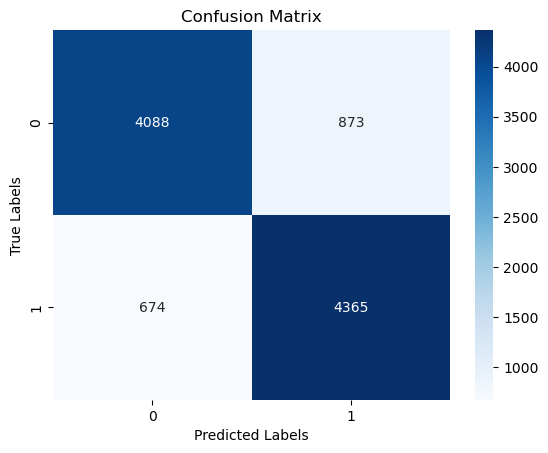

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

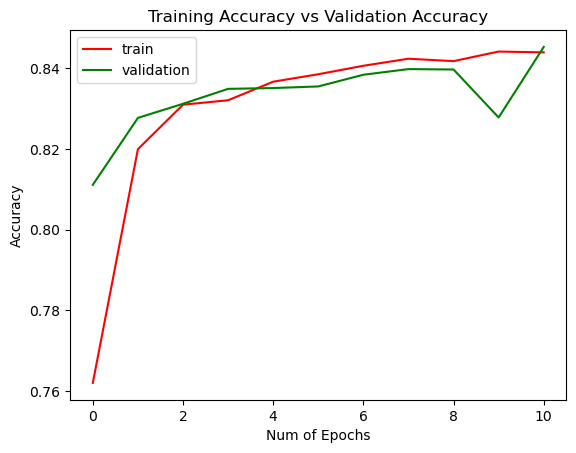

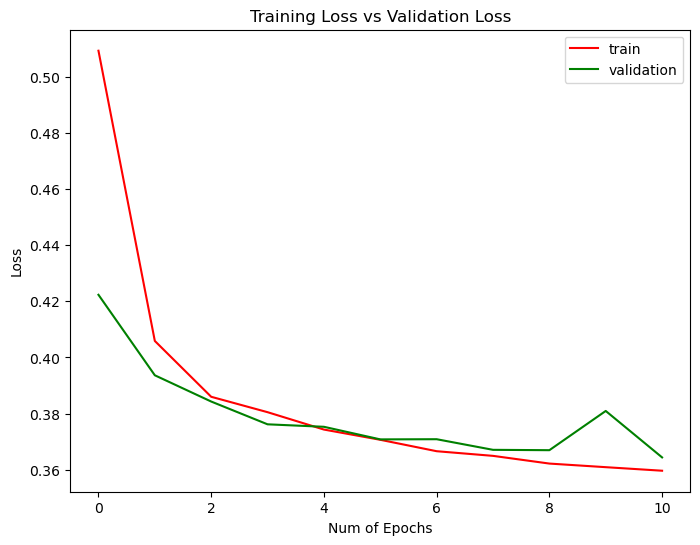

In [8]:
import matplotlib.pyplot as plt
print(snn)

# Results
plt.figure(0)  
plt.plot(snn.history['accuracy'],'r')  
plt.plot(snn.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(snn.history['loss'],'r')  
plt.plot(snn.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()

In [9]:
model.save("CrossLnigualModel_MultiLingualEmbedding_WithFineTune_Report.h5")



C:\Users\ALI\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Fine Tunning on Arabic

In [10]:
from tensorflow.keras.models import load_model

# Load the saved Keras model
model = load_model("CrossLnigualModel_MultiLingualEmbedding_WithFineTune_Report.h5")

In [11]:
df_ = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df_.shape)
# df = df.head(500)
# Select the first 500 rows of the dataset
df = df_.iloc[:500]

# Select the next 500 rows of the dataset
df2 = df_.iloc[500:1000]
# print(df1.shape)
print(df2.shape)
# df.head()

# determine the minimum number of rows for each rating value
min_count = df["rating"].value_counts().min()
min_count = 40
# subset the original dataset for each rating value
df_1 = df[df["rating"] == 1]
df_2 = df[df["rating"] == 2]
df_4 = df[df["rating"] == 4]
df_5 = df[df["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

import pandas as pd
from sklearn.model_selection import train_test_split



X = np.vstack(df['arabic_Embeddings']) 
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


(105698, 7)
(500, 7)


In [12]:
y_train
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# fit the encoder to the values and transform the values to binary values
binary_y_train = le.fit_transform(y_train)
binary_y_train

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1])

In [13]:
from sklearn.metrics import accuracy_score
snn = model.fit(X_train, binary_y_train)

# Evaluate the performance of the Model on the testing set
y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
y_pred

1/1 [==============================] - 0s 38ms/step


array([[0.94158524],
       [0.9818897 ],
       [0.99912465],
       [0.9996635 ],
       [0.34634814],
       [0.19334346],
       [0.99999774],
       [0.3718949 ],
       [0.999927  ],
       [0.99998623],
       [0.9996135 ],
       [0.9443033 ],
       [0.88764346],
       [0.71816856],
       [0.06789319],
       [0.99332225],
       [0.9999998 ],
       [0.7818766 ],
       [0.99976295],
       [0.8129721 ],
       [0.99999976],
       [0.09533411],
       [0.99993724],
       [0.81436783],
       [0.02799775],
       [0.89553815],
       [0.9969501 ],
       [0.39960602],
       [0.99999577],
       [0.99992454],
       [0.9352495 ],
       [0.99998146]], dtype=float32)

In [14]:
import numpy as np

# example threshold value
threshold = 0.5
# convert values to binary using threshold
binary_y_pred = np.where(y_pred > threshold, 1, 0)

print(binary_y_pred)
# convert values to binary using threshold
binary_y_test = le.fit_transform(y_test)
binary_y_test

[[1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]]


array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0])

In [15]:
accuracy = accuracy_score(binary_y_test, binary_y_pred)
print("Accuracy:", accuracy)

print(classification_report(binary_y_test, binary_y_pred))

Accuracy: 0.65625
              precision    recall  f1-score   support

           0       0.86      0.38      0.52        16
           1       0.60      0.94      0.73        16

    accuracy                           0.66        32
   macro avg       0.73      0.66      0.63        32
weighted avg       0.73      0.66      0.63        32



# Save the model

In [22]:

import joblib
joblib.dump(model, 'NN_Multi_En_Ar_MModel.pkl')

import pickle
filename = 'NN_Multi_En_Ar_MModel.sav'
pickle.dump(model, open(filename, 'wb'))

model = joblib.load('NN_Multi_En_Ar_MModel.pkl')
model = pickle.load(open(filename, 'rb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [24]:

# determine the minimum number of rows for each rating value
min_count = df2["rating"].value_counts().min()
min_count = 40
# subset the original dataset for each rating value
df_1 = df2[df2["rating"] == 1]
df_2 = df2[df2["rating"] == 2]
df_4 = df2[df2["rating"] == 4]
df_5 = df2[df2["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings



In [25]:
X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = model.predict(X_test)


5/5 [==============================] - 0s 2ms/step


In [26]:
# example threshold value
threshold = 0.5
# convert values to binary using threshold
binary_y_pred = np.where(y_pred > threshold, 1, 0)

# print(binary_y_pred)
# convert values to binary using threshold
binary_y_test = le.fit_transform(y_test)
# binary_y_test

accuracy = accuracy_score(binary_y_test, binary_y_pred)
print("Accuracy:", accuracy)
print(classification_report(binary_y_test, binary_y_pred))

Accuracy: 0.63125
              precision    recall  f1-score   support

           0       0.84      0.33      0.47        80
           1       0.58      0.94      0.72        80

    accuracy                           0.63       160
   macro avg       0.71      0.63      0.59       160
weighted avg       0.71      0.63      0.59       160



[[26 54]
 [ 5 75]]


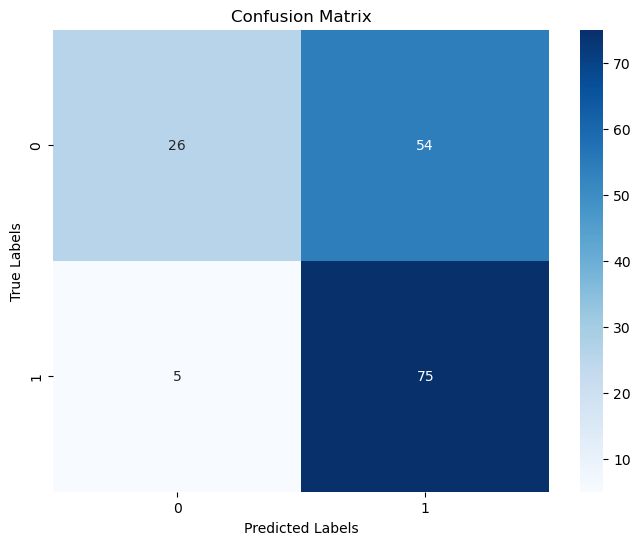

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(binary_y_test, binary_y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# French - Fine Tune - Test

In [28]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample = sample.head(500)

# Apply sentence embeddings to first column of dataframe
reviews = final_sample['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample['french_Embeddings'] = reviews_embeddings

X_test = np.vstack(final_sample['french_Embeddings']) 
y_test = final_sample['label']
y_pred = model.predict(X_test)


16/16 [==============================] - 0s 2ms/step


C:\Users\ALI\AppData\Local\Temp\ipykernel_14256\3878833022.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample['french_Embeddings'] = reviews_embeddings


In [29]:
from sklearn.metrics import classification_report
# Evaluate the performance of the model on the testing set
# y_pred = model.predict(X_test_concatenated_array)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.76      0.67       250
           1       0.67      0.47      0.55       250

    accuracy                           0.62       500
   macro avg       0.63      0.62      0.61       500
weighted avg       0.63      0.62      0.61       500



[[191  59]
 [132 118]]


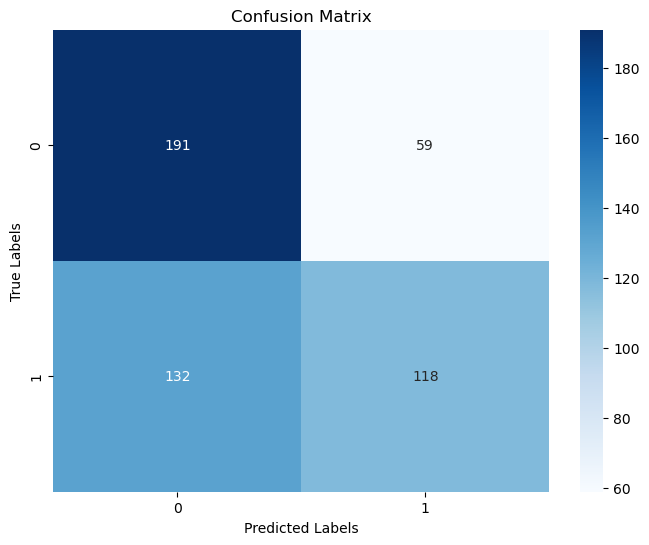

In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [31]:
import pandas as pd

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample_1 = sample.head(500)


# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample_2 = sample.head(500)
# Apply sentence embeddings to first column of dataframe
reviews = final_sample_1['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample_1['french_Embeddings'] = reviews_embeddings

# Apply sentence embeddings to first column of dataframe
reviews = final_sample_2['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample_2['french_Embeddings'] = reviews_embeddings
import pandas as pd
from sklearn.model_selection import train_test_split



X = np.vstack(final_sample_1['french_Embeddings']) 
y = final_sample_1['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


snn = model.fit(X_train, y_train)

# Evaluate the performance of the Model on the testing set
y_pred = model.predict(X_test)
# from sklearn.preprocessing import LabelEncoder
# # create a LabelEncoder object
# le = LabelEncoder()

# # fit the encoder to the values and transform the values to binary values
# binary_y_pred = le.fit_transform(y_pred)


C:\Users\ALI\AppData\Local\Temp\ipykernel_14256\518730249.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample_2['french_Embeddings'] = reviews_embeddings


4/4 [==============================] - 0s 2ms/step


In [32]:
y_pred

array([[0.9984729 ],
       [0.12930557],
       [0.13216433],
       [0.5660801 ],
       [0.5425408 ],
       [0.9971588 ],
       [0.93405944],
       [0.01970488],
       [0.29720724],
       [0.03390836],
       [0.79635835],
       [0.87779   ],
       [0.5697361 ],
       [0.76161635],
       [0.99573296],
       [0.06803942],
       [0.0939106 ],
       [0.877907  ],
       [0.91570544],
       [0.02567626],
       [0.03796222],
       [0.9513004 ],
       [0.07359482],
       [0.0127228 ],
       [0.97480345],
       [0.48263875],
       [0.75569797],
       [0.5242009 ],
       [0.0771881 ],
       [0.02745845],
       [0.21063408],
       [0.05967167],
       [0.01544321],
       [0.30173686],
       [0.10951139],
       [0.2652093 ],
       [0.8541739 ],
       [0.88214105],
       [0.49326077],
       [0.56651825],
       [0.2786015 ],
       [0.04421463],
       [0.2767896 ],
       [0.04139124],
       [0.85536134],
       [0.03714693],
       [0.03794073],
       [0.035

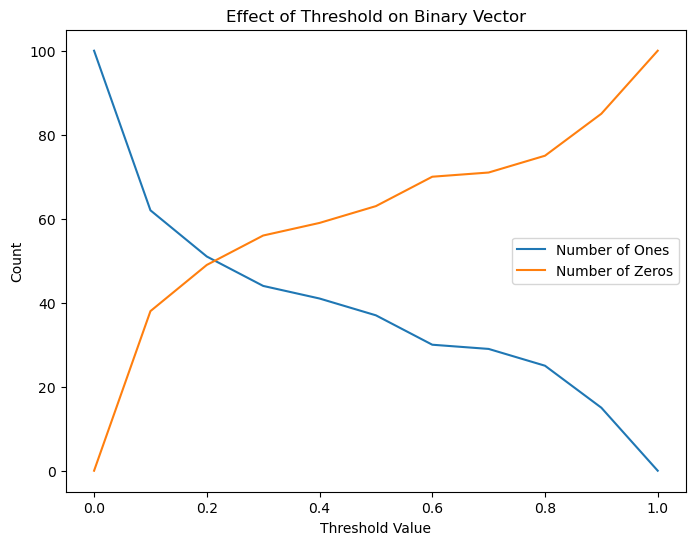

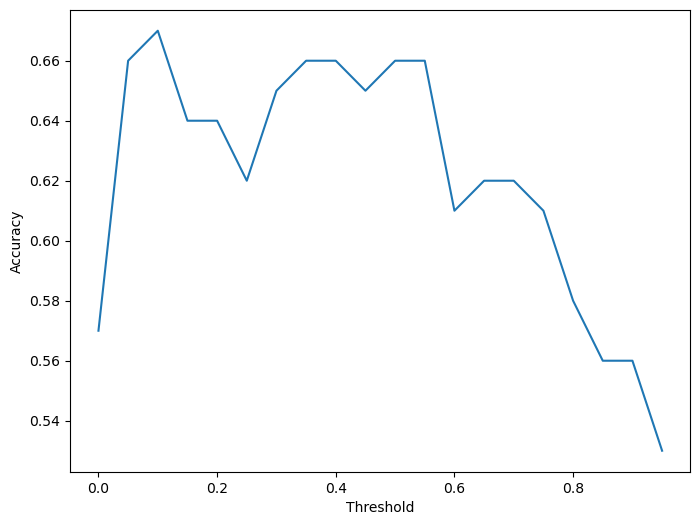

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def threshold_array(arr, threshold):
    return np.array([1 if x >= threshold else 0 for x in arr])

# Example usage
arr = y_pred

threshold_values = np.linspace(0, 1, num=11)
num_ones = []
num_zeros = []

for threshold in threshold_values:
    thresholded_arr = threshold_array(arr, threshold)
    num_ones.append(np.sum(thresholded_arr))
    num_zeros.append(len(thresholded_arr) - np.sum(thresholded_arr))

plt.plot(threshold_values, num_ones, label='Number of Ones')
plt.plot(threshold_values, num_zeros, label='Number of Zeros')
plt.xlabel('Threshold Value')
plt.ylabel('Count')
plt.title('Effect of Threshold on Binary Vector')
plt.legend()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# create a sample binary array and corresponding true labels
bin_arr = y_pred
labels = y_test

# define a range of threshold values to test
thresholds = np.arange(0, 1.0, 0.05)

# calculate the accuracy for each threshold value
accuracies = []
for threshold in thresholds:
    pred_labels = np.where(bin_arr > threshold, 1, 0)
    accuracy = accuracy_score(labels, pred_labels)
#     print(accuracy)
    accuracies.append(accuracy)

# plot the threshold values against the accuracies
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [34]:
# Find the maximum accuracy
max_accuracy = max(accuracies)

# Find the corresponding threshold value for the maximum accuracy
max_threshold = thresholds[accuracies.index(max_accuracy)]

# Print the maximum accuracy and corresponding threshold value
print("Maximum accuracy:", max_accuracy)
print("Corresponding threshold value:", max_threshold)

Maximum accuracy: 0.67
Corresponding threshold value: 0.1


In [35]:
from sklearn.metrics import classification_report
# Evaluate the performance of the model on the testing set
# y_pred = model.predict(X_test_concatenated_array)
y_pred = (y_pred > max_threshold).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.56      0.59        43
           1       0.69      0.75      0.72        57

    accuracy                           0.67       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.67      0.67      0.67       100



[[24 19]
 [14 43]]


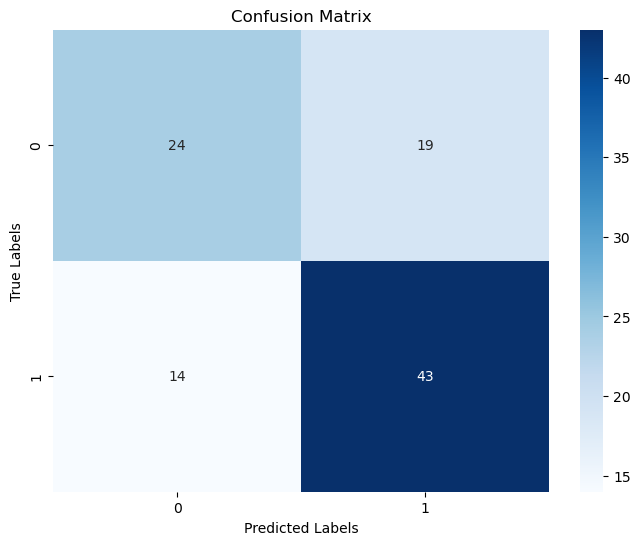

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# Save the model

In [38]:

import joblib
joblib.dump(model, 'NN_Multi_En_Ar_Fr_MModel.pkl')

import pickle
filename = 'NN_Multi_En_Ar_Fr_MModel.sav'
pickle.dump(model, open(filename, 'wb'))

model = joblib.load('NN_Multi_En_Ar_Fr_MModel.pkl')
model = pickle.load(open(filename, 'rb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [39]:
X_test = np.vstack(final_sample_2['french_Embeddings']) 
y_test = final_sample_2['label']
y_pred = model.predict(X_test)

y_pred


16/16 [==============================] - 0s 2ms/step


array([[3.79407257e-02],
       [3.63717139e-01],
       [1.09511390e-01],
       [3.36100943e-02],
       [1.42362922e-01],
       [7.54478797e-02],
       [7.57522285e-02],
       [4.87583354e-02],
       [6.46678388e-01],
       [7.96358347e-01],
       [1.43795451e-02],
       [3.54119502e-02],
       [2.41734684e-01],
       [2.57612973e-01],
       [5.41916899e-02],
       [1.27255306e-01],
       [9.61831033e-01],
       [1.01267457e-01],
       [1.07494425e-02],
       [8.09628606e-01],
       [2.77962923e-01],
       [9.93224502e-01],
       [9.79066551e-01],
       [3.61735463e-01],
       [3.60628329e-02],
       [2.24287137e-01],
       [9.94178772e-01],
       [2.62476504e-01],
       [2.44549185e-01],
       [1.91087767e-01],
       [8.77906978e-01],
       [3.57122034e-01],
       [5.55791080e-01],
       [8.55361342e-01],
       [3.56849171e-02],
       [6.53429985e-01],
       [2.32327245e-02],
       [1.27822664e-02],
       [3.48134674e-02],
       [1.83498971e-02],


In [40]:
y_test

1173475    1
192695     0
872381     1
700904     0
734514     0
          ..
630141     0
1129245    1
792909     1
1417207    1
265764     0
Name: label, Length: 500, dtype: int64

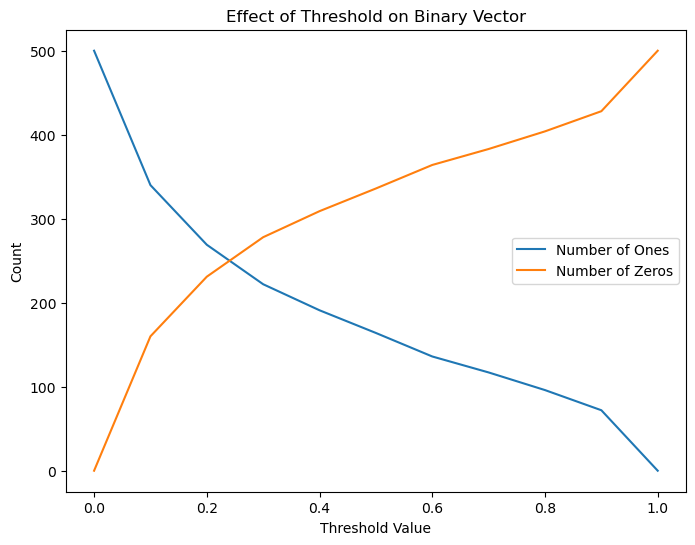

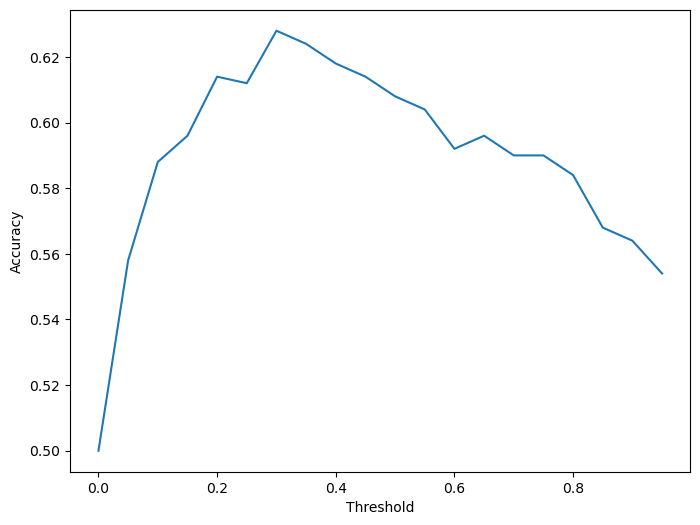

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def threshold_array(arr, threshold):
    return np.array([1 if x >= threshold else 0 for x in arr])

# Example usage
arr = y_pred

threshold_values = np.linspace(0, 1, num=11)
num_ones = []
num_zeros = []

for threshold in threshold_values:
    thresholded_arr = threshold_array(arr, threshold)
    num_ones.append(np.sum(thresholded_arr))
    num_zeros.append(len(thresholded_arr) - np.sum(thresholded_arr))

plt.plot(threshold_values, num_ones, label='Number of Ones')
plt.plot(threshold_values, num_zeros, label='Number of Zeros')
plt.xlabel('Threshold Value')
plt.ylabel('Count')
plt.title('Effect of Threshold on Binary Vector')
plt.legend()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# create a sample binary array and corresponding true labels
bin_arr = y_pred
labels = y_test

# define a range of threshold values to test
thresholds = np.arange(0, 1.0, 0.05)

# calculate the accuracy for each threshold value
accuracies = []
for threshold in thresholds:
    pred_labels = np.where(bin_arr > threshold, 1, 0)
    accuracy = accuracy_score(labels, pred_labels)
#     print(accuracy)
    accuracies.append(accuracy)

# plot the threshold values against the accuracies
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [42]:
# Find the maximum accuracy
max_accuracy = max(accuracies)

# Find the corresponding threshold value for the maximum accuracy
max_threshold = thresholds[accuracies.index(max_accuracy)]

# Print the maximum accuracy and corresponding threshold value
print("Maximum accuracy:", max_accuracy)
print("Corresponding threshold value:", max_threshold)

Maximum accuracy: 0.628
Corresponding threshold value: 0.30000000000000004


In [43]:
y_test

1173475    1
192695     0
872381     1
700904     0
734514     0
          ..
630141     0
1129245    1
792909     1
1417207    1
265764     0
Name: label, Length: 500, dtype: int64

In [44]:
y_pred

array([[3.79407257e-02],
       [3.63717139e-01],
       [1.09511390e-01],
       [3.36100943e-02],
       [1.42362922e-01],
       [7.54478797e-02],
       [7.57522285e-02],
       [4.87583354e-02],
       [6.46678388e-01],
       [7.96358347e-01],
       [1.43795451e-02],
       [3.54119502e-02],
       [2.41734684e-01],
       [2.57612973e-01],
       [5.41916899e-02],
       [1.27255306e-01],
       [9.61831033e-01],
       [1.01267457e-01],
       [1.07494425e-02],
       [8.09628606e-01],
       [2.77962923e-01],
       [9.93224502e-01],
       [9.79066551e-01],
       [3.61735463e-01],
       [3.60628329e-02],
       [2.24287137e-01],
       [9.94178772e-01],
       [2.62476504e-01],
       [2.44549185e-01],
       [1.91087767e-01],
       [8.77906978e-01],
       [3.57122034e-01],
       [5.55791080e-01],
       [8.55361342e-01],
       [3.56849171e-02],
       [6.53429985e-01],
       [2.32327245e-02],
       [1.27822664e-02],
       [3.48134674e-02],
       [1.83498971e-02],


In [45]:
binary_y_pred = np.where(y_pred >= 0.5, 1, 0)

binary_y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
    

In [46]:
from sklearn.metrics import classification_report
# Evaluate the performance of the model on the testing set
# y_pred = loaded_model.predict(X_test_concatenated_array)
# y_pred = (y_pred > max_threshold).astype(int)
print(classification_report(y_test, binary_y_pred))

              precision    recall  f1-score   support

           0       0.58      0.78      0.67       250
           1       0.66      0.44      0.53       250

    accuracy                           0.61       500
   macro avg       0.62      0.61      0.60       500
weighted avg       0.62      0.61      0.60       500



[[195  55]
 [141 109]]


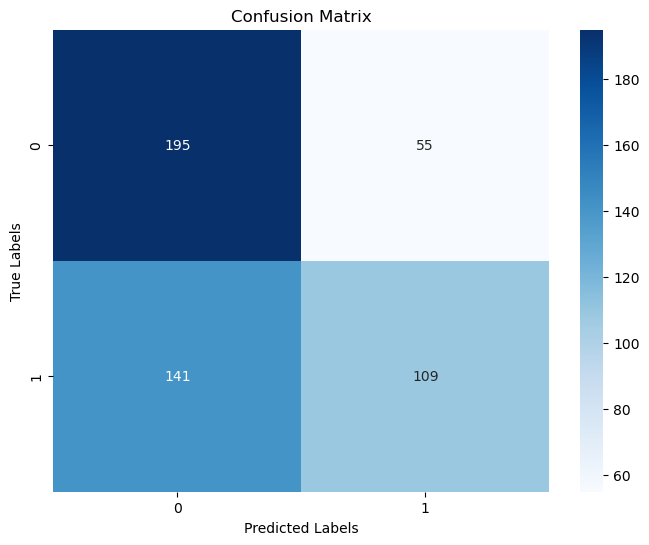

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, binary_y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()